# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.192461,True,5.905620
1,-0.650659,False,-1.580940
2,1.634266,True,7.301445
3,-0.073967,False,1.289995
4,1.011934,False,2.609897
...,...,...,...
995,-0.177530,True,3.624020
996,-1.312116,False,-3.316824
997,-0.911466,False,-2.108801
998,1.229815,True,6.461280


<AxesSubplot:xlabel='v0'>

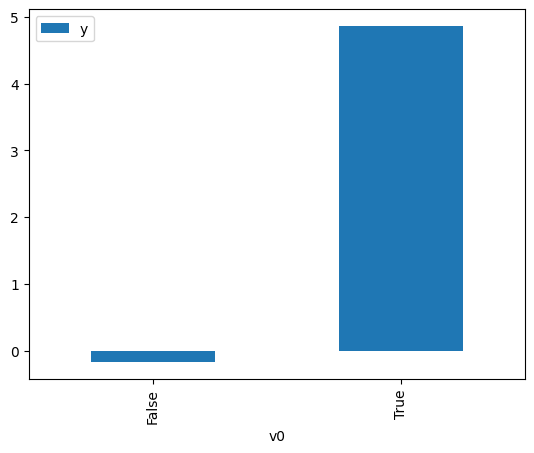

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

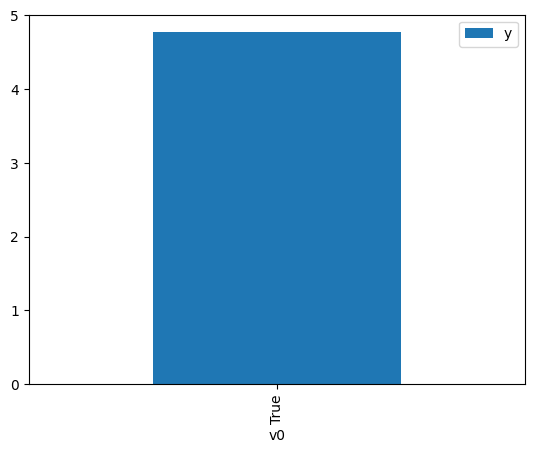

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.702106,False,2.245385,0.222060,4.503283
1,-0.911515,False,-1.080701,0.812534,1.230717
2,-0.206246,False,-0.429327,0.568960,1.757591
3,-0.056223,False,0.049903,0.506175,1.975602
4,0.352553,False,0.008331,0.339748,2.943362
...,...,...,...,...,...
995,0.542807,False,2.115698,0.271871,3.678222
996,1.598840,False,4.358762,0.059221,16.885818
997,1.776042,False,3.460066,0.044610,22.416384
998,0.551450,False,-0.719643,0.268996,3.717527


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.256487,True,9.298311,0.899193,1.112109
1,0.066093,True,4.718854,0.545251,1.834017
2,-1.648124,True,1.181225,0.062482,16.004484
3,0.704418,True,7.597190,0.778612,1.284336
4,-0.540044,True,3.046778,0.301465,3.317137
...,...,...,...,...,...
995,0.181573,True,4.595707,0.592951,1.686480
996,-0.200392,True,4.778308,0.433461,2.307010
997,-1.633903,True,1.140010,0.063902,15.649038
998,-0.072904,True,4.203184,0.486798,2.054241


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9947.
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        23:38:19   Log-Likelihood:                         -1457.0
No. Observations:                1000   AIC:                                      2918.
Df Residuals:                     998   BIC:                                      2928.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0626      0.037     55.709      0.000       1.990       2.135
x2             4.9812      0.050     99.511      0.000       4.883       5.079
==============================================================================
Omnibus:                        2.972   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.862
Skew:                           0.128   Prob(JB):                        0.239
Kurtosis:                       3.058   Cond. No.                         1.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""